#Statistics 72556 Homework #4
Written by Raafi Rahman in Google Colab

##Chapter 17 Problem 9
Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as CIFAR10 if you want a bigger challenge. Regardless of the dataset you’re using, follow these steps:

####Library imports

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.model_selection import train_test_split

#try:
#    # %tensorflow_version only exists in Colab.
#    %tensorflow_version 2.x
#    IS_COLAB = True
#except Exception:
#    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#if not tf.config.list_physical_devices('GPU'):
#    print("No GPU was detected. CNNs can be very slow without a GPU.")
#    if IS_COLAB:
#        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
import random
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

tf.test.gpu_device_name()

'/device:GPU:0'

####Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.

Import and Split Data

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [ ]:
def show_reconstructions(model, images, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
from tensorflow import keras
from skimage.color import rgb2gray

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

In [ ]:
#X_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_train])
#X_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_test])

In [ ]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

truck


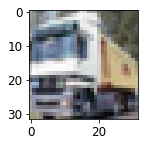

In [ ]:
fig = plt.figure(figsize=(2,2))
plt.imshow(X_train[1], cmap="binary", interpolation="nearest")
print(class_names[y_train[1][0]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


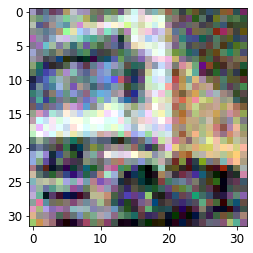

In [ ]:
noise = keras.layers.GaussianNoise(0.1)
plt.imshow(noise(X_train[1], training=True), cmap="binary", interpolation="nearest")

In [ ]:
X_train[0].shape

(32, 32, 3)

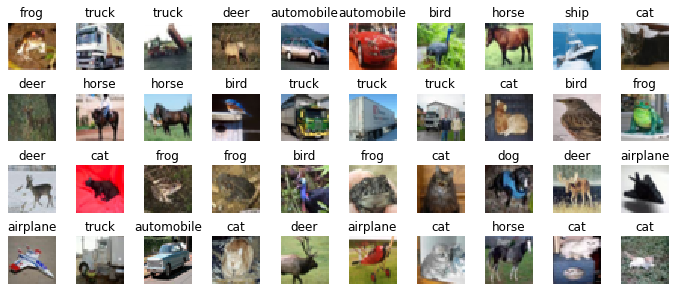

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index][0]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [1]:
tf.random.set_seed(305)
np.random.seed(305)

denoising_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.2, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(64, kernel_size=16, padding="same", activation="selu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="selu"),
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation="selu", input_shape=[256]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=4, strides=2,
                                 padding="same", activation="sigmoid")
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=5)

NameError: ignored

In [ ]:
denoising_ae.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 256)               4243776   
                                                                 
 sequential_16 (Sequential)  (None, 32, 32, 3)         2106883   
                                                                 
Total params: 6,350,659
Trainable params: 6,350,659
Non-trainable params: 0
_________________________________________________________________


####Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


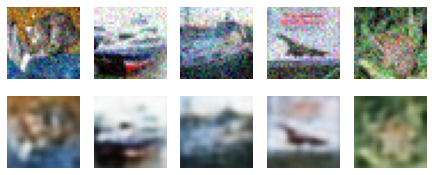

In [ ]:
tf.random.set_seed(305)
np.random.seed(305)

noise = keras.layers.GaussianNoise(0.1)
show_reconstructions(denoising_ae, noise(X_test, training=True))
plt.show()

####Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

In [ ]:
newAE = keras.models.clone_model(denoising_encoder)

In [ ]:
classifier = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[256]),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
newAE.trainable = False

In [ ]:
model = keras.models.Sequential([newAE, classifier])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train[0:500], y_train[0:500], epochs=20)

Epoch 1/20
16/16 [==============================] - 1s 7ms/step - loss: 2.2889 - accuracy: 0.1400
Epoch 2/20
16/16 [==============================] - 0s 6ms/step - loss: 2.2286 - accuracy: 0.1880
Epoch 3/20
16/16 [==============================] - 0s 7ms/step - loss: 2.1246 - accuracy: 0.2140
Epoch 4/20
16/16 [==============================] - 0s 7ms/step - loss: 2.0164 - accuracy: 0.2800
Epoch 5/20
16/16 [==============================] - 0s 7ms/step - loss: 1.9527 - accuracy: 0.2880
Epoch 6/20
16/16 [==============================] - 0s 7ms/step - loss: 1.8574 - accuracy: 0.3440
Epoch 7/20
16/16 [==============================] - 0s 7ms/step - loss: 1.8272 - accuracy: 0.3600
Epoch 8/20
16/16 [==============================] - 0s 7ms/step - loss: 1.8212 - accuracy: 0.3360
Epoch 9/20
16/16 [==============================] - 0s 6ms/step - loss: 1.7679 - accuracy: 0.3760
Epoch 10/20
16/16 [==============================] - 0s 7ms/step - loss: 1.6494 - accuracy: 0.4120
Epoch 11/20
16/16 [

'cat'

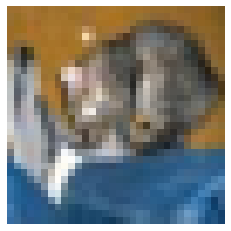

In [ ]:
img = 0

plot_image(X_test[img])
index = model.predict(np.expand_dims(X_test[img], axis=0))
class_names[np.argmax(index)]